In [1]:
# Visualización de datos y gráficos
import matplotlib.pyplot as plt
# Computación numérica
import numpy as np

In [2]:
# Parámetros constantes conocidos

# Largo del receptáculo / m
Lx = 5

# Alto del receptáculo / m
H = Lx

# Difusividad de la especie oxígeno  [m^2 s^-1]
k = 1e-4

# Concentración inicial   [mol m^-3]
w0 = 0

# Concentration de equilibrio en el mar  [mol m^-3]
w_mar = 5

# Concentración interfase aire-agua  [mol m^-3]
w_aire = 2

# Concentración en el fondo   [mol m^-3]
w_fondo = 10

#Consumo constante
sigma_const = 2e-7  # Tasa de consumo CONSTANTE [mg/l/s]

In [ ]:
# Grilla estructurada en coordenadas x y z para representar receptáculo cuadrado

# Definimos el número de puntos deseados en nuestra grilla
Nx = 451
Nz = Nx

# Definimos vectores con las coordenadas de cada punto en el espacio donde se evaluará la solución.
x_grilla = np.linspace(0.0, Lx, Nx)
z_grilla = np.linspace(0.0, H, Nz)

# Calculamos el paso o espaciamiento para cada coordenada.
dx = Lx/(Nx-1)
dz = H/(Nz-1)

# Imprimimos los resultados
print("dx = %.3f, dz = %.3f m" % (dx, dz))


dx = 0.011, dy = 0.011 m


Solo difusión

In [4]:
#Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = k/(dx**2)

# Coeficiente correspondiente a nodo vecino izquierdo
b = k/(dx**2) #varía -vx/dx

# Coeficiente correspondiente a nodo vecino superior
c = k/(dz**2)

# Coeficiente correspondiente a nodo vecino inferior
d = k/(dz**2)  #varía -vz/dz

# Coeficiente correspondiente a nodo central
e = -2*k/(dx**2) - 2*k/(dz**2)  #varía +vx/dx + vz/dz

#REVISAR VALOR
# Coeficiente correspondiente a término constante
f = sigma_const

# Definir valores constantes para parámetros SOR

# Parámetro de sobre-relajación
omega = 1.45

# Tolerancia, criterio de convergencia
tol = 2*1e-3 # -> ideal es 10**-4 pero para hacer que converja más rápido

In [5]:
# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA[-1,1:] = ( 4*wA[-2, 1:] - wA[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA[0:-1, -1] = w_fondo

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA[i+1,j] + b*wA[i-1,j] + c*wA[i,j+1] + d*wA[i, j-1] + e*wA[i,j] - f


                    # Actualizar el valor de concentration de aroma
                    wA[i,j] += -omega*residuo_nodo / e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA[-1,1:] = ( 4*wA[-2, 1:] - wA[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA[0:-1, -1] = w_fondo

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA[0, 1:-1] = w_mar

    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos

    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)

    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 3.047e-02
Residuo total: 7.483e-03
Residuo total: 5.232e-03
Residuo total: 4.235e-03
Residuo total: 3.640e-03
Residuo total: 3.234e-03
Residuo total: 2.935e-03
Residuo total: 2.702e-03
Residuo total: 2.514e-03
Residuo total: 2.359e-03
Residuo total: 2.227e-03
Residuo total: 2.114e-03
Residuo total: 2.016e-03


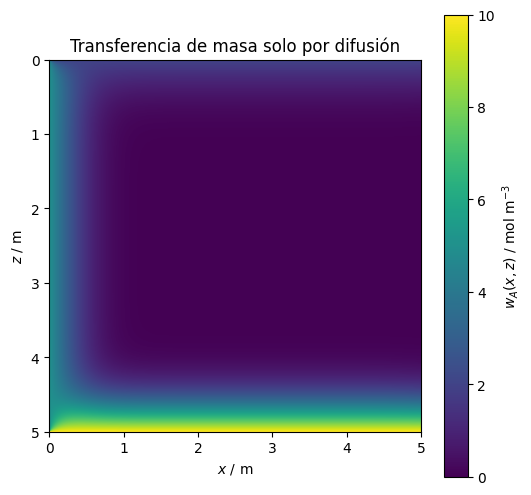

In [6]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

'''Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente el índice "j", asociado a la coordenada y, avanza hacia "abajo" mientras que en el dominio físico avanza hacia arriba'''

plt.imshow((np.transpose(wA)), origin="upper", extent =[0, Lx,H,0])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa solo por difusión")

plt.show()

Alterando la concentración del fondo, a una valor mucho mayor

In [ ]:
w_fondo2 = 100

# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA2 = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA2[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA2[-1,1:] = ( 4*wA[-2, 1:] - wA[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA2[0:-1, -1] = w_fondo2

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA2[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA2[i+1,j] + b*wA2[i-1,j] + c*wA2[i,j+1] + d*wA2[i, j-1] + e*wA2[i,j] - f


                    # Actualizar el valor de concentration de aroma
                    wA2[i,j] += -omega*residuo_nodo / e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA2[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA2[-1,1:] = ( 4*wA2[-2, 1:] - wA2[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA2[0:-1, -1] = w_fondo2

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA2[0, 1:-1] = w_mar


    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos


    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)


    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 1.933e-01
Residuo total: 4.732e-02
Residuo total: 3.315e-02
Residuo total: 2.688e-02
Residuo total: 2.314e-02
Residuo total: 2.059e-02
Residuo total: 1.871e-02
Residuo total: 1.724e-02
Residuo total: 1.606e-02
Residuo total: 1.508e-02
Residuo total: 1.426e-02
Residuo total: 1.355e-02
Residuo total: 1.292e-02
Residuo total: 1.238e-02
Residuo total: 1.189e-02
Residuo total: 1.145e-02
Residuo total: 1.105e-02
Residuo total: 1.069e-02
Residuo total: 1.036e-02
Residuo total: 1.006e-02
Residuo total: 9.779e-03
Residuo total: 9.518e-03
Residuo total: 9.276e-03
Residuo total: 9.049e-03
Residuo total: 8.837e-03
Residuo total: 8.637e-03
Residuo total: 8.450e-03
Residuo total: 8.272e-03
Residuo total: 8.105e-03
Residuo total: 7.946e-03
Residuo total: 7.795e-03
Residuo total: 7.651e-03
Residuo total: 7.515e-03
Residuo total: 7.384e-03
Residuo total: 7.259e-03
Residuo total: 7.140e-03
Residuo total: 7.026e-03
Residuo total: 6.916e-03
Residuo total: 6.811e-03
Residuo total: 6.710e-03


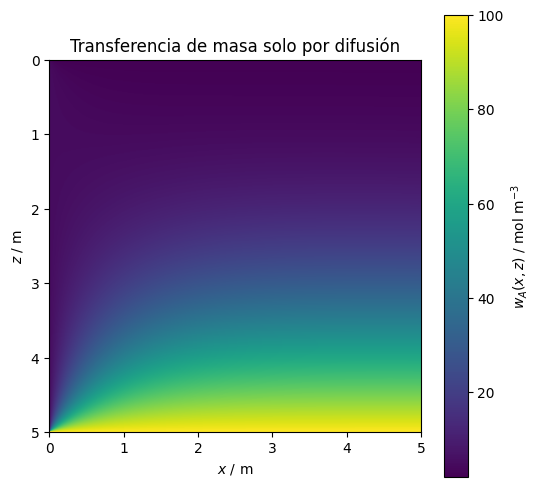

In [8]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

'''Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente
el índice "j", asociado a la coordenada y,
avanza hacia "abajo" mientras que en el dominio físico
avanza hacia arriba'''

plt.imshow((np.transpose(wA2)), origin="upper", extent =[0, Lx,H,0])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa solo por difusión")

plt.show()

Solo advección (o convección)

In [50]:
vx = 10 #m/s
vz = 2 #m/s
omega = 1

In [51]:
#Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = 0

# Coeficiente correspondiente a nodo vecino izquierdo
b = vx/dx

# Coeficiente correspondiente a nodo vecino superior
c = 0

# Coeficiente correspondiente a nodo vecino inferior
d = vz/dz

# Coeficiente correspondiente a nodo central
e = -(vx/dx + vz/dz)

#REVISAR VALOR
# Coeficiente correspondiente a término constante
f = sigma_const

In [52]:
# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA3 = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA3[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA3[-1,1:] = ( 4*wA[-2, 1:] - wA[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA3[0:-1, -1] = w_fondo

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA3[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA3[i+1,j] + b*wA3[i-1,j] + c*wA3[i,j+1] + d*wA3[i, j-1] + e*wA3[i,j] - f

                    # Actualizar el valor de concentration de aroma
                    wA3[i,j] += -omega*residuo_nodo/e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA3[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA3[-1,1:] = (4*wA3[-2, 1:] - wA3[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA3[0:-1, -1] = w_fondo

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA3[0, 1:-1] = w_mar

    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos

    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)

    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 1.075e+01
Residuo total: 2.043e+01
Residuo total: 1.940e+01
Residuo total: 1.836e+01
Residuo total: 1.733e+01
Residuo total: 1.630e+01


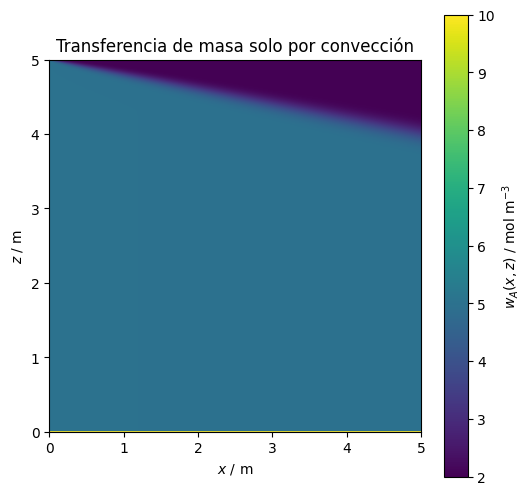

In [53]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

'''Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente 
el índice "j", asociado a la coordenada y, avanza hacia "abajo" mientras que en el dominio físico avanza hacia arriba'''

plt.imshow((np.transpose(wA3)), origin="upper", extent =[0, Lx,0,H])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa solo por convección")

plt.show()

Con los dos fenómenos

In [42]:
#Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = k/(dx**2)

# Coeficiente correspondiente a nodo vecino izquierdo
b = k/(dx**2) -vx/dx

# Coeficiente correspondiente a nodo vecino superior
c = k/(dz**2)

# Coeficiente correspondiente a nodo vecino inferior
d = k/(dz**2) -vz/dz

# Coeficiente correspondiente a nodo central
e = -2*k/(dx**2) - 2*k/(dz**2) +vx/dx + vz/dz

#REVISAR VALOR
# Coeficiente correspondiente a término constante
f = sigma_const

In [43]:
# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration de oxígeno
wA4 = np.ones((Nx,Nz)) * w0 #*concentración al inicial

# Aplicamos las condiciones de borde

# borde "superior" (x, z=0) esto es para todo i en j = 0
wA4[:,0] = w_aire

# borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
wA4[-1,1:] = ( 4*wA4[-2, 1:] - wA4[-3, 1:])/3

# borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
wA4[0:-1, -1] = w_fondo

# borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
wA4[0, 1:-1] = w_mar

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:

    # Residuo viejo
    residuo_tmp = residuo_total

    # Reiniciar residuo total para sumar residuos en cada nodo
    resid_total = 0

    # Contador para checker boarding
    cnt_nodos = 0

    # Recorrer puntos internos del dominio
    for i in range(0,Nx):
        for j in range(0,Nz):

            # Checker-boarding para garantizar convergencia, resolviendo nodos pares e impares alternadamente
            if((i+j)%2) == cnt_it%2:

                # Calcular residuo para nodo (i,j)
                if (i > 0) & (i < Nx-1) & (j > 0) & (j < Nz-1):
                    residuo_nodo = a*wA4[i+1,j] + b*wA4[i-1,j] + c*wA4[i,j+1] + d*wA4[i, j-1] + e*wA4[i,j] - f


                    # Actualizar el valor de concentration de aroma
                    wA4[i,j] += -omega*residuo_nodo / e

                    # Actualizar la suma de residuos absolutos
                    residuo_total += abs(residuo_nodo)

                # Aumentar contador de nodos
                cnt_nodos += 1

    # Actualizar condiciones de borde arreglo solución de concentraciones
    # luego de un checker-boarding completo (nodos pares e impares)
    if cnt_it%2 == 0:
        # borde "superior" (x, z=0) esto es para todo i en j = 0
        wA4[:,0] = w_aire

        # borde derecho (x=L, z) esto es en i = Nx-1 para 1 <= j <= Nz-1
        wA4[-1,1:] = ( 4*wA4[-2, 1:] - wA4[-3, 1:])/3

        # borde "inferior" (x, z=H) esto es para 0 <= i <= Nx-2 en j = Nz-1
        wA4[0:-1, -1] = w_fondo

        # borde izquierdo (x=0, z) esto es en i = 0 para 1 <= j <=  Ny-1
        wA4[0, 1:-1] = w_mar


    # Calcular residuo medio
    residuo_total = residuo_total/cnt_nodos


    # Imprimir residuo cada 100 iteraciones
    if cnt_it%100 ==0:
        print("Residuo total: %.3e" % residuo_total)


    # Aumentar contador de iteraciones
    cnt_it = cnt_it + 1

Residuo total: 1.076e+01
Residuo total: 1.874e+01
Residuo total: 1.797e+01
Residuo total: 1.720e+01
Residuo total: 1.643e+01
Residuo total: 1.566e+01
Residuo total: 1.486e+01
Residuo total: 2.775e-01


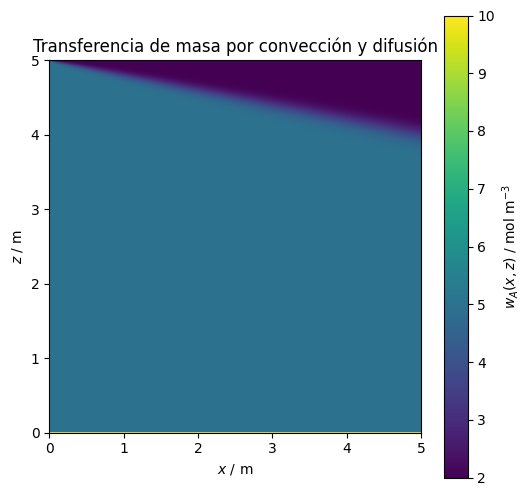

In [46]:
# Creamos el lienzo para graficar
fig = plt.subplots(figsize=[6,6])

'''Invertimos la coordenada vertical de la matriz cA, ya que computacionalmente el índice "j", asociado a la coordenada y, avanza hacia "abajo" mientras que en el dominio físico avanza hacia arriba'''

plt.imshow((np.transpose(wA4)), origin="upper", extent =[0, Lx,0,H])
plt.colorbar(label=r"$w_A(x,z)$ / mol m$^{-3}$")
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$z$ / m')
plt.title("Transferencia de masa por convección y difusión")

plt.show()